# Import libraries

In [4]:
!pip install lime

In [5]:
import pandas as pd 
import os
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [6]:
data = pd.read_csv("/kaggle/input/brain-cancer-mri-dataset/dataset.csv")

In [7]:
data

,label,number_of_files
0,brain_glioma,2004
1,brain_menin,2004
2,brain_tumor,2048


# split data to train, val and test

In [ ]:
import os
import shutil
import random

random.seed(42)

original_data_dir = "/kaggle/input/brain-cancer-mri-dataset/Brain_Cancer raw MRI data/Brain_Cancer"

base_dir = "/kaggle/working/brain_dataset"

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

classes = ["brain_tumor", "brain_glioma", "brain_menin"]

for split in ['train', 'val', 'test']:
    for cls in classes:
        os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)

for cls in classes:
    src_folder = os.path.join(original_data_dir, cls)
    files = [f for f in os.listdir(src_folder) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    random.shuffle(files)

    total = len(files)
    train_end = int(train_ratio * total)
    val_end = train_end + int(val_ratio * total)

    train_files = files[:train_end]
    val_files = files[train_end:val_end]
    test_files = files[val_end:]

    for file in train_files:
        shutil.copy(os.path.join(src_folder, file), os.path.join(base_dir, 'train', cls, file))
    for file in val_files:
        shutil.copy(os.path.join(src_folder, file), os.path.join(base_dir, 'val', cls, file))
    for file in test_files:
        shutil.copy(os.path.join(src_folder, file), os.path.join(base_dir, 'test', cls, file))

print("Dataset successfully split into train, val, and test.")


Dataset successfully split into train, val, and test.


# visualize some samples

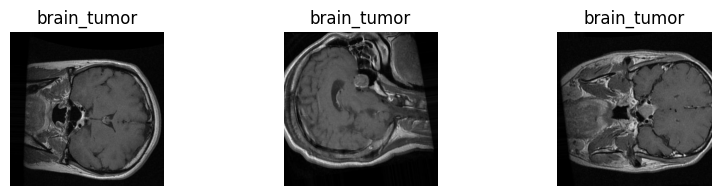

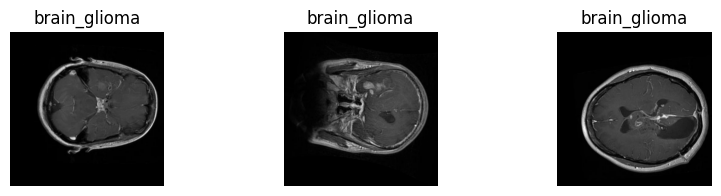

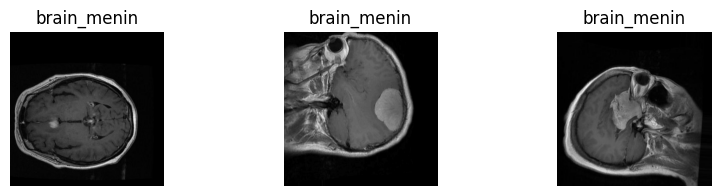

In [9]:
def show_images(directory, classe, num_images=3):
    class_path = os.path.join(directory, classe)
    image_files = os.listdir(class_path)[:num_images]
    plt.figure(figsize=(10, 2))
    for i, file in enumerate(image_files):
        img = Image.open(os.path.join(class_path, file))
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(classe)
    plt.show()

show_images("/kaggle/input/brain-cancer-mri-dataset/Brain_Cancer raw MRI data/Brain_Cancer", 'brain_tumor')
show_images("/kaggle/input/brain-cancer-mri-dataset/Brain_Cancer raw MRI data/Brain_Cancer", 'brain_glioma')
show_images("/kaggle/input/brain-cancer-mri-dataset/Brain_Cancer raw MRI data/Brain_Cancer", 'brain_menin')

# Define a data augmentator to augmente data

In [10]:
data_generator = ImageDataGenerator(
    rescale=1/255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

# Load training data
train_data = data_generator.flow_from_directory(
    base_dir + '/train',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=True
)

# Load validation data
val_data = data_generator.flow_from_directory(
    base_dir + '/val',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

# Load test data
test_data = data_generator.flow_from_directory(
    base_dir + '/test',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

Found 4237 images belonging to 3 classes.
Found 907 images belonging to 3 classes.
Found 912 images belonging to 3 classes.


# Check for balanced classes in each dataset (train, test, val) 

In [11]:
import numpy as np

def print_class_distribution(generator, dataset_name):
    
    class_names = list(generator.class_indices.keys())
    class_counts = dict.fromkeys(class_names, 0)

    for cls, idx in generator.class_indices.items():
        class_counts[cls] = np.sum(generator.classes == idx)

    print(f"\nClass distribution in {dataset_name}:")
    for cls in class_names:
        print(f"{cls}: {class_counts[cls]} samples")

# Example usage:
print_class_distribution(train_data, "Training Data")
print_class_distribution(val_data, "Validation Data")
print_class_distribution(test_data, "Test Data")



Class distribution in Training Data:
brain_glioma: 1402 samples
brain_menin: 1402 samples
brain_tumor: 1433 samples

Class distribution in Validation Data:
brain_glioma: 300 samples
brain_menin: 300 samples
brain_tumor: 307 samples

Class distribution in Test Data:
brain_glioma: 302 samples
brain_menin: 302 samples
brain_tumor: 308 samples


# Model Creation

In [12]:
image_size = 224

## Custom CNN

In [41]:
from tensorflow.keras import layers, models, Input


custom_cnn = models.Sequential([
    layers.Input(shape=(None, None, 3)),               
    layers.Resizing(image_size, image_size),      

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])


In [43]:
custom_cnn.compile(
    optimizer=Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### Training

In [44]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_cb = EarlyStopping(
    monitor='val_loss',   
    patience=3,           
    restore_best_weights=True
)

custom_cnn_history = custom_cnn.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    callbacks=[early_stopping_cb]
)

Epoch 1/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 73s 238ms/step - accuracy: 0.5341 - loss: 1.6528 - val_accuracy: 0.3330 - val_loss: 4.2588
Epoch 2/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 56s 212ms/step - accuracy: 0.6285 - loss: 0.8293 - val_accuracy: 0.5788 - val_loss: 1.0116
Epoch 3/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 57s 213ms/step - accuracy: 0.7171 - loss: 0.6974 - val_accuracy: 0.6825 - val_loss: 0.7082
Epoch 4/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 56s 213ms/step - accuracy: 0.7596 - loss: 0.5914 - val_accuracy: 0.8115 - val_loss: 0.4646
Epoch 5/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.8021 - loss: 0.5047 - val_accuracy: 0.7222 - val_loss: 0.6426
Epoch 6/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 56s 211ms/step - accuracy: 0.8129 - loss: 0.4592 - val_accuracy: 0.5413 - val_loss: 1.1954
Epoch 7/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 56s 211ms/step - accuracy: 0.8244 - loss: 0.4579 - val_accuracy: 0.6604 - val_loss: 0.8723


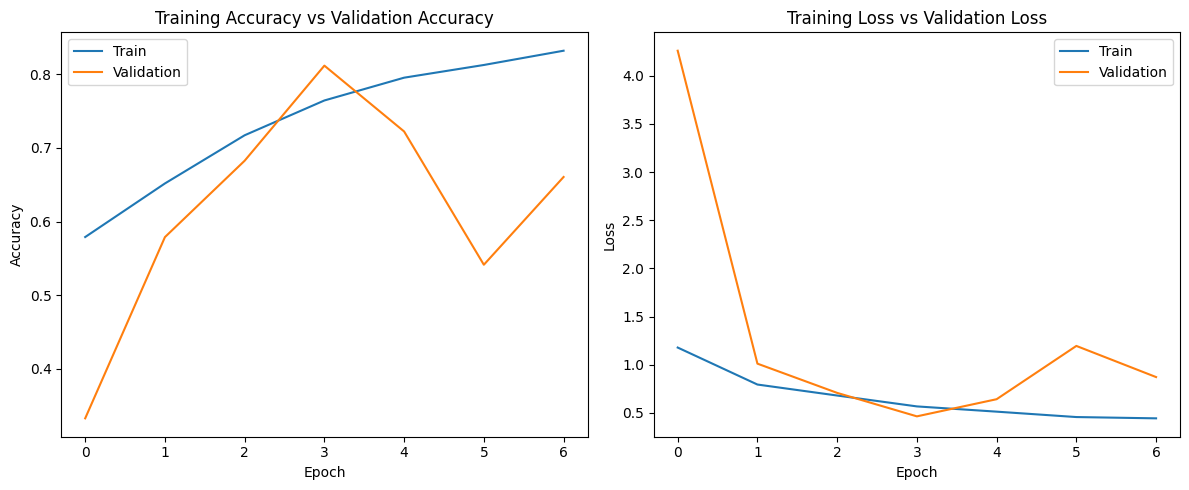

In [45]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(custom_cnn_history.history['accuracy'], label='Train')
plt.plot(custom_cnn_history.history['val_accuracy'], label='Validation')
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(custom_cnn_history.history['loss'], label='Train')
plt.plot(custom_cnn_history.history['val_loss'], label='Validation')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Evaluation

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

y_pred_prob = custom_cnn.predict(test_data)

y_pred = np.argmax(y_pred_prob, axis=1)

y_true = test_data.classes

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')  # use 'macro' if you want unweighted
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy : {accuracy*100:.4f}")
print(f"Precision: {precision*100:.4f}")
print(f"Recall   : {recall*100:.4f}")
print(f"F1 Score : {f1*100:.4f}")


57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step
Accuracy : 76.9737
Precision: 81.1259
Recall   : 76.9737
F1 Score : 77.4130


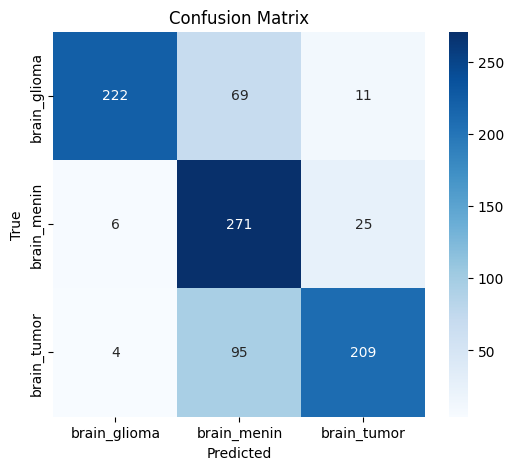

In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
class_names = list(test_data.class_indices.keys())


plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## MobileNet

In [35]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Resizing, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

input_tensor = Input(shape=(None, None, 3))

x = Resizing(image_size, image_size)(input_tensor)

base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=x)
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(3, activation='softmax')(x)

mobile_net = Model(inputs=input_tensor, outputs=predictions)

/tmp/ipykernel_35/1071928240.py:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=x)


In [36]:
mobile_net.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

### Training

In [37]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_cb = EarlyStopping(
    monitor='val_loss',   
    patience=3,           
    restore_best_weights=True
)

mobile_net_history = mobile_net.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    callbacks=[early_stopping_cb]
)

Epoch 1/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 73s 235ms/step - accuracy: 0.5160 - loss: 1.0794 - val_accuracy: 0.8412 - val_loss: 0.4416
Epoch 2/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.7740 - loss: 0.5373 - val_accuracy: 0.8864 - val_loss: 0.3289
Epoch 3/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 54s 205ms/step - accuracy: 0.8097 - loss: 0.4594 - val_accuracy: 0.8942 - val_loss: 0.3017
Epoch 4/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 55s 207ms/step - accuracy: 0.8209 - loss: 0.4239 - val_accuracy: 0.8986 - val_loss: 0.2698
Epoch 5/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 55s 207ms/step - accuracy: 0.8504 - loss: 0.3760 - val_accuracy: 0.9074 - val_loss: 0.2589
Epoch 6/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 55s 207ms/step - accuracy: 0.8578 - loss: 0.3663 - val_accuracy: 0.9162 - val_loss: 0.2416
Epoch 7/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 55s 207ms/step - accuracy: 0.8638 - loss: 0.3524 - val_accuracy: 0.9107 - val_loss: 0.2422
Epoch 8/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.8582 - loss: 0

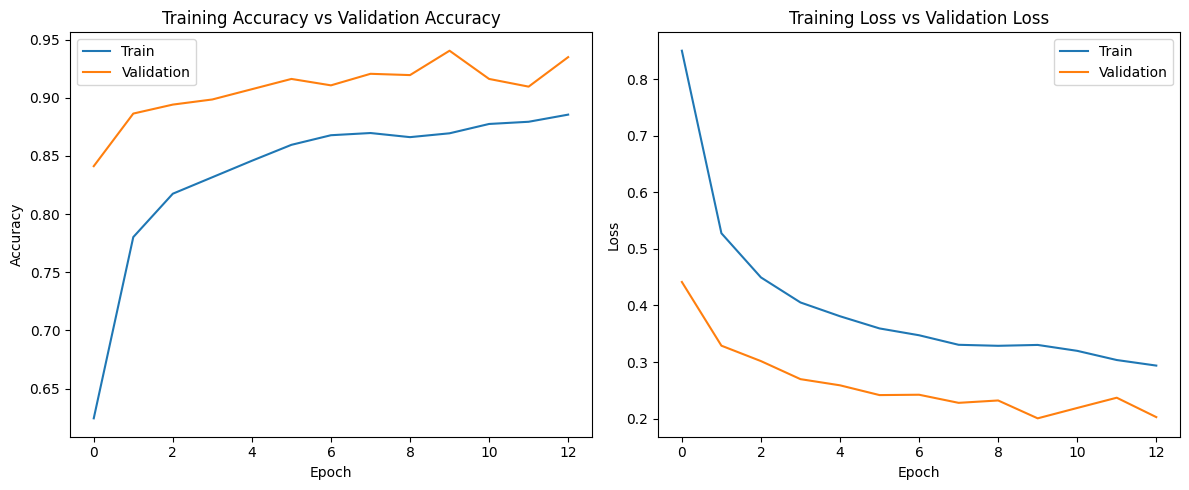

In [38]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(mobile_net_history.history['accuracy'], label='Train')
plt.plot(mobile_net_history.history['val_accuracy'], label='Validation')
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mobile_net_history.history['loss'], label='Train')
plt.plot(mobile_net_history.history['val_loss'], label='Validation')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Evaluation

In [39]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Predict class probabilities
y_pred_prob = mobile_net.predict(test_data)

# Convert to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# True labels from the test generator
y_true = test_data.classes

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy : {accuracy*100:.4f}")
print(f"Precision: {precision*100:.4f}")
print(f"Recall   : {recall*100:.4f}")
print(f"F1 Score : {f1*100:.4f}")


57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 170ms/step
Accuracy : 92.2149
Precision: 92.3131
Recall   : 92.2149
F1 Score : 92.1305


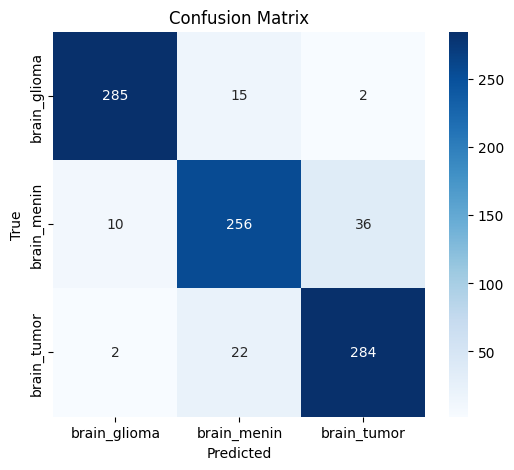

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
class_names = list(test_data.class_indices.keys())


plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Resnet 50

In [29]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

input_tensor = Input(shape=(None, None, 3))
x = Resizing(image_size, image_size)(input_tensor)

base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=x)
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(3, activation='softmax')(x)

resnet_50 = Model(inputs=base_model.input, outputs=predictions)

In [30]:
resnet_50.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

### Training

In [31]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_cb = EarlyStopping(
    monitor='val_loss',   
    patience=3,           
    restore_best_weights=True
)

resnet_50_history = resnet_50.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    callbacks=[early_stopping_cb]
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_585']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


265/265 ━━━━━━━━━━━━━━━━━━━━ 80s 253ms/step - accuracy: 0.3426 - loss: 1.2753 - val_accuracy: 0.4234 - val_loss: 1.0917
Epoch 2/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 58s 219ms/step - accuracy: 0.3534 - loss: 1.1507 - val_accuracy: 0.3418 - val_loss: 1.0965
Epoch 3/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 59s 223ms/step - accuracy: 0.3542 - loss: 1.1137 - val_accuracy: 0.3308 - val_loss: 1.0783
Epoch 4/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 59s 221ms/step - accuracy: 0.3747 - loss: 1.0950 - val_accuracy: 0.3705 - val_loss: 1.0713
Epoch 5/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 59s 222ms/step - accuracy: 0.3907 - loss: 1.0847 - val_accuracy: 0.4024 - val_loss: 1.0667
Epoch 6/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 58s 220ms/step - accuracy: 0.3818 - loss: 1.0849 - val_accuracy: 0.5336 - val_loss: 1.0488
Epoch 7/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 58s 220ms/step - accuracy: 0.3991 - loss: 1.0767 - val_accuracy: 0.4587 - val_loss: 1.0517
Epoch 8/30
265/265 ━━━━━━━━━━━━━━━━━━━━ 58s 219ms/step - accuracy: 0.4278 - loss: 1.0675 - val

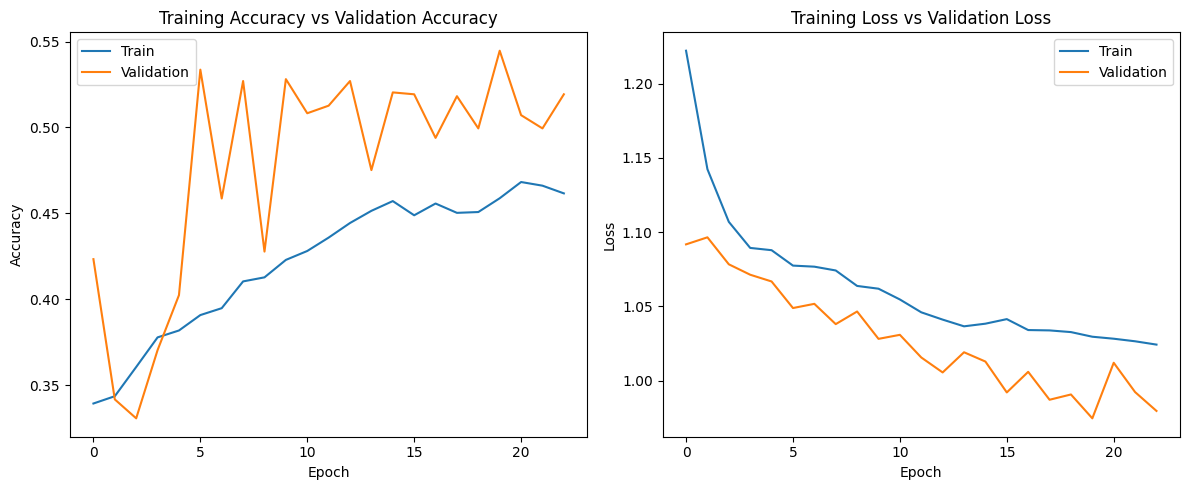

In [32]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(resnet_50_history.history['accuracy'], label='Train')
plt.plot(resnet_50_history.history['val_accuracy'], label='Validation')
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(resnet_50_history.history['loss'], label='Train')
plt.plot(resnet_50_history.history['val_loss'], label='Validation')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Evaluation

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

y_pred_prob = resnet_50.predict(test_data)

y_pred = np.argmax(y_pred_prob, axis=1)

y_true = test_data.classes

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy : {accuracy*100:.4f}")
print(f"Precision: {precision*100:.4f}")
print(f"Recall   : {recall*100:.4f}")
print(f"F1 Score : {f1*100:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_585']
Received: inputs=Tensor(shape=(16, 224, 224, 3))
  warnings.warn(msg)


57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step
Accuracy : 51.9737
Precision: 52.4533
Recall   : 51.9737
F1 Score : 49.8926


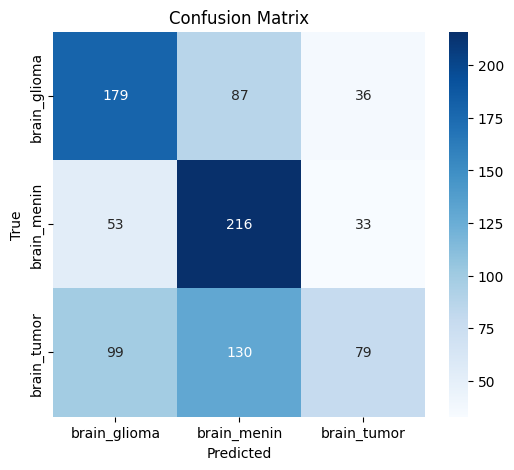

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
class_names = list(test_data.class_indices.keys())


plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Save Best Model

In [40]:
mobile_net.save("Brain_Tumor_model.h5")

# Load Model

In [48]:
from tensorflow.keras.models import load_model

loaded_model = load_model('/kaggle/working/Brain_Tumor_model.h5')
print("model loaded")

model loaded


In [49]:
loaded_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resizing_4 (Resizing)     │ (None, 224, 224, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ resizing_4[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise    

 Total params: 2,422,341 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 2 (12.00 B)

# Explainability using Grad-CAM

## Load image

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = '/kaggle/working/brain_dataset/test/brain_glioma/brain_glioma_0194.jpg'
img = image.load_img(img_path)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

## explain result using a heatmap with Grad-Cam

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_4']]
Received: inputs=Tensor(shape=(1, 512, 512, 3))
  warnings.warn(msg)


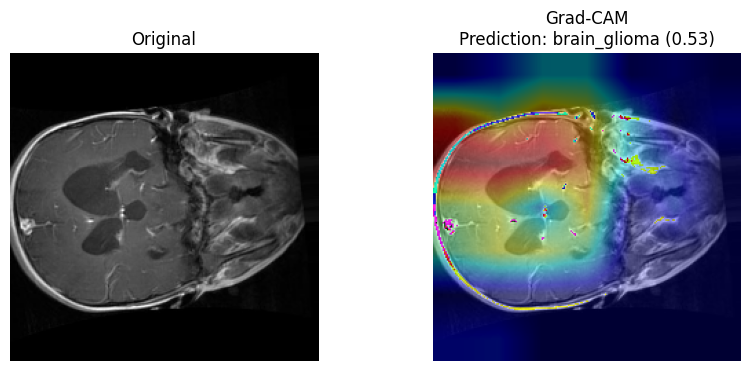

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2


# get the last convolutional layer
grad_model = tf.keras.models.Model(
    [loaded_model.inputs], 
    [loaded_model.get_layer('out_relu').output, loaded_model.output]
)

# compute gradients and predictions
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_array)
    class_index = tf.argmax(predictions[0])
    loss = predictions[:, class_index]

# Compute the gradients of the class output : conv layer output
grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# Weighted combination of forward activation maps
heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs[0]), axis=-1)
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
heatmap = heatmap.numpy()

# Superimpose on original image
img_raw = cv2.imread(img_path)
img_raw = cv2.resize(img_raw, (224, 224))
heatmap_resized = cv2.resize(heatmap, (224, 224))
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
superimposed_img = heatmap_colored * 0.4 + img_raw


predicted_label = class_names[int(class_index)]
confidence = tf.nn.softmax(predictions[0])[class_index].numpy()

# shhow Grad-CAM and original image
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('Original')
plt.imshow(cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f'Grad-CAM\nPrediction: {predicted_label} ({confidence:.2f})')
plt.imshow(cv2.cvtColor(np.uint8(superimposed_img), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


# Explainability using Lime

In [60]:
!pip install lime

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━

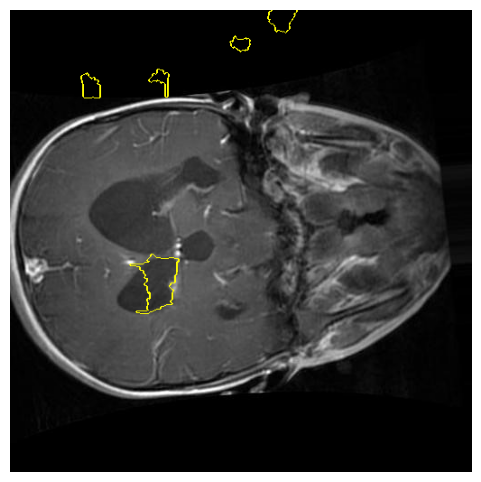

In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np

explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(
    np.array(img_array[0]),               
    classifier_fn=loaded_model.predict,    
    top_labels=3, 
    hide_color=0, 
    num_samples=1000
)

temp, mask = explanation.get_image_and_mask(
    label=class_index.numpy(),       
    positive_only=True,              
    hide_rest=False,                 
    num_features=5,                  
    min_weight=0.0
)

# temp is the image with boundaries marked and scale it back
img_with_boundaries = mark_boundaries(temp / 255.0, mask)

plt.figure(figsize=(6, 6))
plt.imshow(mark_boundaries(img_array[0], mask))
plt.axis('off')
plt.show()

